In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
from numpy.linalg import inv
plt.rcParams.update({'font.size': 14})

# Multivariate Gaussian Gibbs Sampler

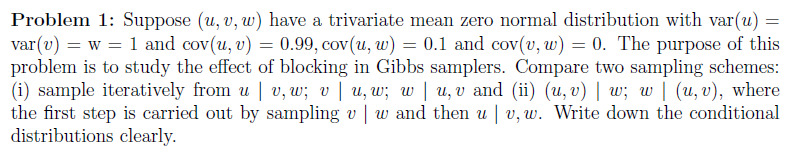

To answer the last question I chose write down the conditional distributions in functional form so that I can condition on any subset of elements of my random vector.

In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
from numpy.random import multivariate_normal as MVN

class Gaussian:
    def sample(self, N_samples):
        samples =  MVN(self.mu, self.Sigma, size = self.NSAMPLES)
        return pd.DataFrame(samples)

    def conditional(self, idx, obs, mu, Sigma):
        mu_idx = mu[idx]
        _mu = np.delete(mu, idx)
        S12 = np.delete(Sigma[idx], idx, axis = 1)
        S21 = np.delete(Sigma[:,idx], idx, axis = 0)
        S22 = np.array([np.delete(Sigma[i], idx) for i in range(Sigma.shape[0]) if i not in idx])
        S11 = np.array([Sigma[i][idx] for i in range(Sigma.shape[0]) if i in idx])
        S22_inverse = inv(S22)
        mu_hat = mu_idx + (S12@S22_inverse)@(obs-_mu)
        cov_hat = S11 - (S12@S22_inverse)@S21
        return MVN(mu_hat, cov_hat)

class MVNGibbs(Gaussian):
  def __init__(self, mu, Sigma, NSAMPLES, BURNIN):
    self.mu, self.Sigma = mu, Sigma
    self.NSAMPLES, self.BURNIN = NSAMPLES, BURNIN
 
  def block_sampler(self):
    # (u, v)|w and w|(u,v)
    X0 = np.zeros(3)
    samples = [X0]
    for i in range(self.NSAMPLES+self.BURNIN):
      X_new = samples[-1].copy()
      X_new[[0,1]] = self.conditional([0,1], X_new[2], self.mu, self.Sigma)
      X_new[2] = self.conditional([2], X_new[[0,1]], self.mu, self.Sigma)
      samples.append(X_new)
    return pd.DataFrame(samples[self.BURNIN:])

In [ ]:
def plot_joint(df):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
  ax1.scatter(df[0], df[2], color = 'k', s = 10, alpha = .75)
  ax2.scatter(df[0], df[1], color = 'k', s = 10, alpha = .75)
  ax3.scatter(df[2], df[0], color = 'k', s = 10, alpha = .75)
  ax1.set_xlabel('v')
  ax1.set_ylabel('w')
  ax2.set_xlabel('u')
  ax2.set_ylabel('v')
  ax3.set_xlabel('w')
  ax3.set_ylabel('u')
  plt.tight_layout()
  plt.show()
    
def plot_kdes(df_true, uni, block):
  fig, ax = plt.subplots(2,3, figsize = (12,8), sharex = True, sharey = True)
  sns.kdeplot(df_true[0], color = 'k', ax = ax[0,0], lw = 3)
  sns.kdeplot(df_true[1], color = 'k', ax = ax[0,1], lw = 3)
  sns.kdeplot(df_true[2], color = 'k', ax = ax[0,2], lw = 3)
  sns.kdeplot(uni[0], color = 'r', ax = ax[0,0], lw = 3)
  sns.kdeplot(uni[1], color = 'r', ax = ax[0,1], lw = 3)
  sns.kdeplot(uni[2], color = 'r', ax = ax[0,2], lw = 3)
  sns.kdeplot(df_true[0], color = 'k', ax = ax[1,0], lw = 3)
  sns.kdeplot(df_true[1], color = 'k', ax = ax[1,1], lw = 3)
  sns.kdeplot(df_true[2], color = 'k', ax = ax[1,2], lw = 3)
  sns.kdeplot(block[0], color = 'r', ax = ax[1,0], lw = 3)
  sns.kdeplot(block[1], color = 'r', ax = ax[1,1], lw = 3)
  sns.kdeplot(block[2], color = 'r', ax = ax[1,2], lw = 3)
  ax[1,0].set_xlabel('u')
  ax[1,1].set_xlabel('v')
  ax[1,2].set_ylabel('w')
  fig.legend(['True Samples', 'Gibbs Samples'])
  plt.tight_layout()
  plt.show()

In [ ]:
mu = np.zeros(3)
Sigma = np.array([[1, .99, 0.1],
                  [.99, 1, 0],
                  [.1, 0, 1]])

I use numpy's multivariate normal module to validate the convergence of my samples.

In [ ]:
N_SAMPLES, BURNIN = 2000, 500
G = MVNGibbs(mu, Sigma, N_SAMPLES, BURNIN)

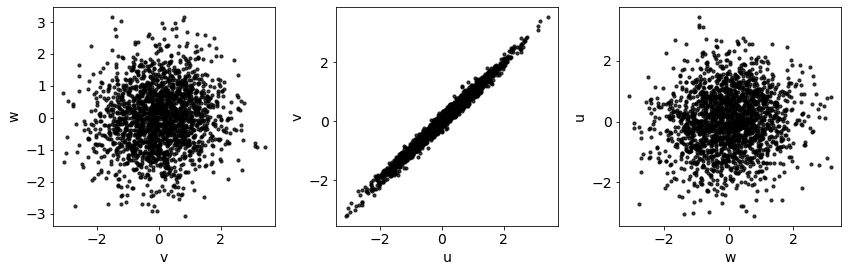

In [ ]:
true = G.sample(N_SAMPLES-BURNIN)
plot_joint(true)

In [ ]:
gibbs1 = G.univariate_sampler()
gibbs2 = G.block_sampler()

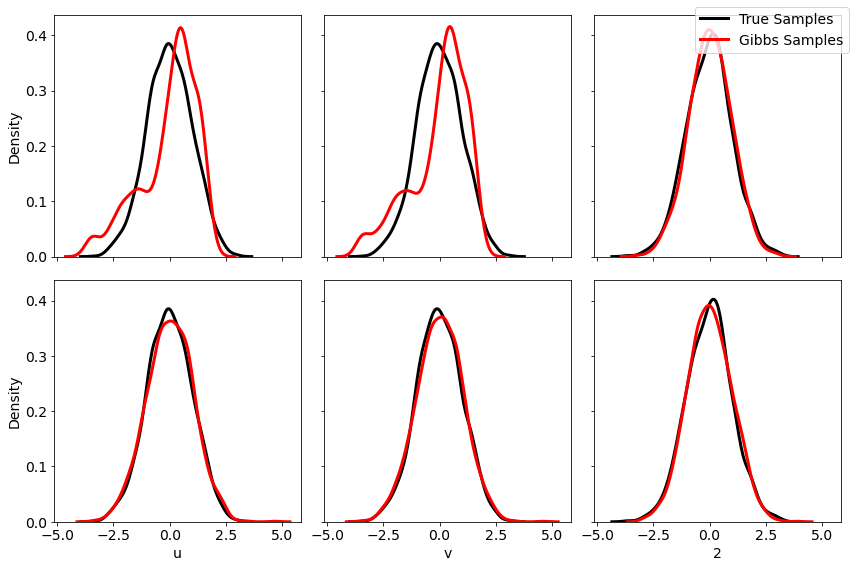

In [ ]:
plot_kdes(true, gibbs1, gibbs2)

Notice how poorly we are sampling $u$ and $v$ while $w$ looks good. This is because $Cov(u,v)$ = .99! This makes sense in the context of the univariate sampling procedure. Consider taking sample $u^* \, | \, (v,w)$ then sampling from $v \, | \, (u^*,w)$. Since $u,v$ are highly correlated, the sampler is constrained to explore the support in a more deterministic way / limited way. Whereas since $w$ has low correlation with $u,v$ the samples from $w \, | \, (u,v)$ are not being as constrained by the linear dynamics of the sampler. This is highlighted by how clean the marginal distribition for $w$ is compared to the other two. Clearly the joint dynamics of $u,v$ cause the convergence of their marginal distirbutions to be less efficient. 

That being said, in the limit we should expect both the univariate and blocked Gibbs samplers to converge to the true distribution characterized by $\mu$ and $\Sigma$.

# Probit Regression Using Albert-Chib Data Augmentation

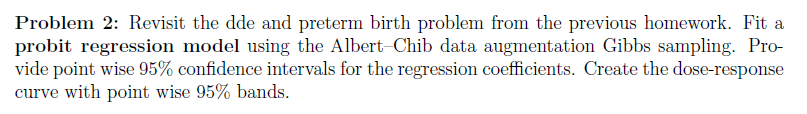

In [ ]:
data = pd.read_csv('DDE.txt', delimiter=' ')
data['x_new'] = (data['x']-data['x'].mean())/data['x'].std()
data['intercept'] = np.ones(len(data))

y = data['y'].values
X = data[['intercept', 'x_new']].values
data.head()

,x,y,z1,z2,z3,z4,z5,x_new,intercept
0,25,0,2.212296,1.062961,0.449211,0.500820,1,-0.260483,1.0
1,16,0,-2.168249,-0.362939,0.611841,1.691256,1,-0.713184,1.0
2,55,1,0.532087,0.862834,1.099728,-0.600676,0,1.248520,1.0
3,15,0,-1.073112,-0.337923,1.424986,0.471173,0,-0.763484,1.0
4,34,0,0.562091,-0.100273,0.611841,0.783605,1,0.192218,1.0


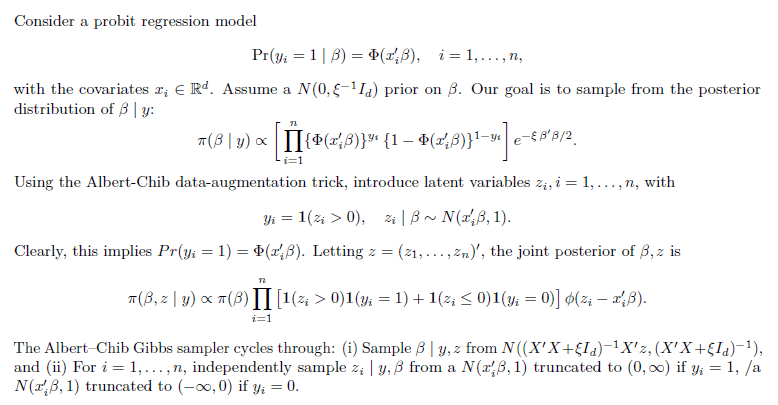

In [ ]:
from scipy.stats import norm, truncnorm

@dataclass
class ACGibbs:
  X : np.array
  y : np.array
  eta : float
  NSAMPLES : int
  BURNIN : int
  THIN : int

  def __post_init__(self):
    self.n, self.d = self.X.shape
    self.M = inv(X.T@X+self.eta*np.eye(self.d))

  def sample_z(self, beta):
    y = self.y.copy()
    # y[y==1] = 1
    y[y==0] = -1
    return y*truncnorm.rvs(a=0, b=np.inf, loc=self.X@beta, scale=1)

  def sample_beta(self, z):
    mu = self.M@self.X.T@z
    return MVN(mu, self.M)

  def sample(self):
    BETA =[np.random.normal(0, 1/self.eta, self.d)]
    Z = [np.random.normal(self.X@BETA[-1], 1, self.n)]
    BI,T = self.BURNIN, self.THIN
    for i in range(self.NSAMPLES*T):
      b_new = self.sample_beta(Z[-1])
      z_new = self.sample_z(BETA[-1])
      BETA.append(b_new)
      Z.append(z_new)
    data_dict = {f'b{i}':np.array(BETA)[BI::T,i] for i in range(self.d)}
    return pd.DataFrame(data_dict)

In [ ]:
def plot_trace(beta):
  d = beta.shape[1]
  fig, ax = plt.subplots(d, 1, figsize = (12, 3*d), sharex = True)
  for i in range(d):
    col = beta.columns[i]
    ax[i].plot(beta[col], color = 'k', lw = 2)
    ax[i].set_ylabel(f'b{i}')
  plt.tight_layout()
  plt.show()

def plot_posterior(beta):
  b0_mu, b1_mu = beta.mean()
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 4))
  fig.suptitle('Posterior Densities')
  sns.kdeplot(beta['b0'], color = 'k', lw = 3, ax = ax0)
  sns.kdeplot(beta['b1'], color = 'k', lw = 3, ax = ax1)
  ax0.set_xlabel('b0')
  ax1.set_xlabel('b1')
  ax0.set_title(f'mu = {round(b0_mu, 4)}')
  ax1.set_title(f'mu = {round(b1_mu, 4)}') 
  plt.tight_layout()
  plt.show()

In [ ]:
eta = .5
NSAMPLES, BURNIN, THIN = 1000, 100, 3
ACG = ACGibbs(X, y, eta, NSAMPLES, BURNIN, THIN)
beta = ACG.sample()

Thinning greatly improves the Gaussianity of our posteriors by removing autocorrelated samples from the Markov chain.

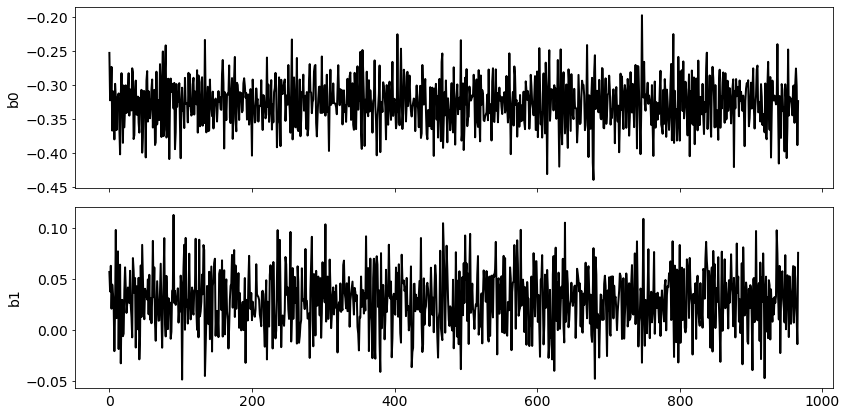

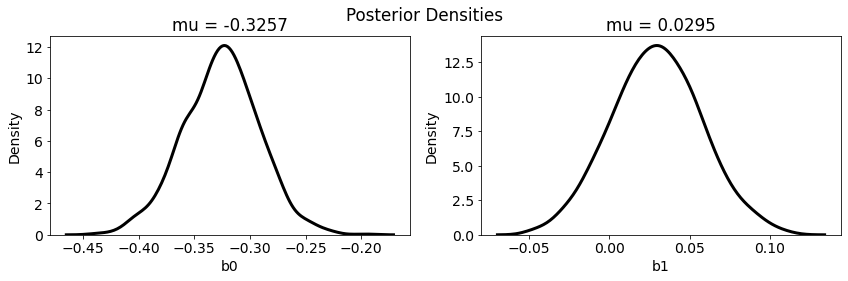

In [ ]:
plot_trace(beta)
plot_posterior(beta)

In [ ]:
beta_mu = beta.mean()
lo, hi = 0.025, 0.975
CI = beta.quantile([lo, hi])
CI.T

,0.025,0.975
b0,-0.396273,-0.258438
b1,-0.026647,0.086856
